## Normalizing Flow Example

Simple Normalizing Flow for MNIST using Residual Blocks in PyTorch.

What it does:
- Implements a residual block
- Implements a normalizing flow using these blocks
- Trains on MNIST by maximizing log-likelihood
- Generates and saves sample images during training

Dependencies:
- torch, torchvision, matplotlib


This implementation is intentionally small and educational rather than highly-optimized.


In [6]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import os
from typing import List
from torchvision import transforms, utils


### Utility Masks

In [7]:
def create_checkerboard_mask(h: int, w: int, invert: bool = False) -> torch.Tensor:
    """Create a binary checkerboard mask of shape (1, h, w)."""
    mask = [[((i + j) % 2) for j in range(w)] for i in range(h)]
    # to numpy
    mask = torch.from_numpy(np.array(mask)).float()
    if invert:
        mask = 1.0 - mask
    return mask.unsqueeze(0)  # (1, h, w)

# For a flattened image we'll produce a mask vector of length 784
def mask_flat_from_checkerboard(h=28, w=28, invert=False) -> torch.Tensor:
    return create_checkerboard_mask(h, w, invert).view(-1)  # (784,)

### Residual Block

Residual block with skip connections.

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.g = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        # Use smaller initialization for better Lipschitz constraint
        for m in self.g.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)
                nn.init.zeros_(m.bias)
        
        self.scale = nn.Parameter(torch.tensor(-2.0))  # Start with small scale

    def forward(self, x):
        # Ensure x has gradients enabled
        if not x.requires_grad:
            x = x.requires_grad_(True)
            
        # Apply scaled residual function with bounded scaling
        scale = torch.sigmoid(self.scale) * 0.5  # Keep scale in [0, 0.5]
        g_x = self.g(x) * scale
        y = x + g_x
        
        # Hutchinson's trace estimator for log-det
        epsilon = torch.randn_like(x)
        
        with torch.enable_grad():
            jvp = torch.autograd.grad(
                outputs=g_x, 
                inputs=x, 
                grad_outputs=epsilon, 
                create_graph=self.training,
                retain_graph=True
            )[0]
        
        # tr(J_g) ≈ ε^T * J_g * ε
        trace_est = torch.sum(epsilon * jvp, dim=1)
        
        # log|det(I + J_g)| ≈ log(1 + tr(J_g)) for better numerical stability
        # Or use: trace_est for small values
        logdet = torch.log1p(trace_est)  # log(1 + x) is more stable
        
        return y, logdet


## Model Architecture

The Normalizing Flow model consists of multiple residual blocks.

In [9]:
class ResidualFlow(nn.Module):
    def __init__(self, dim=784, hidden_dim=512, n_blocks=4):
        super().__init__()
        self.blocks = nn.ModuleList([ResidualBlock(dim, hidden_dim) for _ in range(n_blocks)])

    def forward(self, x):
        logdet_sum = torch.zeros(x.size(0), device=x.device)
        z = x  # Don't recreate tensor - use input directly
        for block in self.blocks:
            z, logdet = block(z)
            logdet_sum += logdet
        return z, logdet_sum

    def inverse(self, z, n_iter=100, tol=1e-6):
        """Fixed-point iteration with optional convergence check."""
        x = z.clone()
        for i in range(n_iter):
            x_prev = x
            for block in reversed(self.blocks):
                x = x - block.g(x) * torch.tanh(block.scale)
            
            # Optional: check convergence
            if i > 10 and torch.norm(x - x_prev) < tol:
                break
        return x

## Model Training

The Normalizing Flow model is trained by maximizing the log-likelihood of the training data. The training loop iterates over the dataset, computes the negative log-likelihood loss, and updates the model parameters using the Adam optimizer. The model's performance is monitored by generating and saving sample images at regular intervals during training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 64
lr = 1e-3
dim = 28 * 28
os.makedirs("outputs", exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.view(-1)),
])

train_dataset = torchvision.datasets.MNIST(root='~/data', 
                                           train=True, 
                                           download=True, 
                                           transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


flow = ResidualFlow(dim=784, hidden_dim=128, n_blocks=4).to(device)

print(flow)
print(f"Number of model parameters: {sum(p.numel() for p in flow.parameters())/1e6:.2f} million")
print(f"Running on: {device}")

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

def gaussian_log_prob(z):
    return -0.5 * (z.pow(2).sum(dim=1) + z.size(1) * math.log(2 * math.pi))

for epoch in range(num_epochs):
    flow.train()
    total_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        
        z, logdet = flow(x)
        
        log_pz = gaussian_log_prob(z)
        loss = -(log_pz + logdet).mean()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        
    print(f"Epoch {epoch}, avg loss: {total_loss / (batch_idx + 1):.4f}, lr: {lr:.6f}")

ResidualFlow(
  (blocks): ModuleList(
    (0-3): 4 x ResidualBlock(
      (g): Sequential(
        (0): Linear(in_features=784, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=784, bias=True)
      )
    )
  )
)
Number of model parameters: 0.87 million
Running on: cuda
NaN detected at epoch 1, batch 13


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Model Testing

The trained Normalizing Flow model can be evaluated by generating new samples from the learned distribution. This is done by sampling from a standard normal distribution and passing the samples through the inverse of the flow to obtain images in the original data space.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved samples to outputs/samples_epoch_29.png


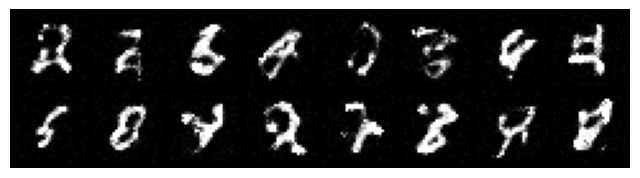

In [ ]:
with torch.no_grad():
    z = torch.randn(16, 784).to(device)
    # Use more iterations for better inverse approximation
    x_gen = flow.inverse(z, n_iter=200)
    
    # Clamp values to valid range [0, 1]
    x_gen = torch.clamp(x_gen, 0, 1)
    
    imgs = x_gen.view(-1, 1, 28, 28).cpu()

import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i,0], cmap='gray')
    plt.axis('off')
plt.suptitle("Residual Flow Generated MNIST Samples")
plt.tight_layout()
plt.savefig('outputs/residual_flow_samples.png')
plt.show()

ResidualFlow(
  (blocks): ModuleList(
    (0-3): 4 x ResidualBlock(
      (g): Sequential(
        (0): Linear(in_features=784, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=784, bias=True)
      )
    )
  )
)
Number of model parameters: 0.87 million
Running on: cuda
Epoch 1/10, Loss: 697.0624
Epoch 2/10, Loss: 744.7508
Epoch 3/10, Loss: 746.6226
Epoch 4/10, Loss: 745.9695
Epoch 5/10, Loss: 745.7300
Epoch 6/10, Loss: 745.4428
Epoch 7/10, Loss: 744.8761
Epoch 8/10, Loss: 744.7945
Epoch 9/10, Loss: 744.7801
Epoch 10/10, Loss: 744.6833


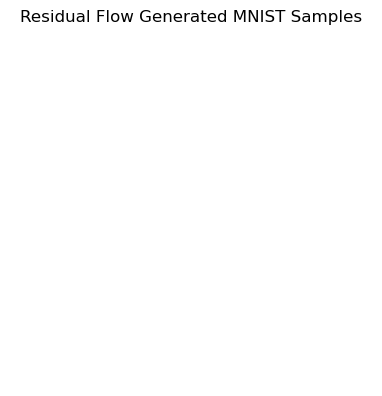

In [ ]:
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 64
lr = 1e-3
dim = 28 * 28
os.makedirs("outputs", exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),  # maps to [0,1]
    # transforms.Lambda(lambda t: (t - 0.5) * 2),  # scale to [-1,1]
    transforms.Lambda(lambda t: t.view(-1)),  # flatten to 784
])
# Load the MNIST train dataset
train_dataset = torchvision.datasets.MNIST(root='~/data', 
                                           train=True, 
                                           download=True, 
                                           transform=transform)

# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='~/data', 
                                          train=False, 
                                          download=True, 
                                          transform=transform)

# Create the test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# -----------------------
# Residual Block
# -----------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.g = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        self.scale = nn.Parameter(torch.zeros(1))  # stability scaling

    def forward(self, x):
        # Apply the residual function with scaling
        g_x = self.g(x) * torch.tanh(self.scale)
        y = x + g_x
        
        # Compute log determinant using Hutchinson's trace estimator
        # log|det(I + J_g)| ≈ tr(J_g) for small Lipschitz constant
        epsilon = torch.randn_like(x)
        
        # Compute J_g * epsilon using vector-Jacobian product
        g_x_eps = torch.autograd.grad(
            outputs=g_x, 
            inputs=x, 
            grad_outputs=epsilon, 
            create_graph=True,
            retain_graph=True
        )[0]
        
        # Hutchinson's estimator: tr(J_g) ≈ ε^T J_g ε
        trace_est = torch.sum(epsilon * g_x_eps, dim=1)
        
        # log|det(I + J_g)| ≈ tr(J_g) for contractive g
        logdet = trace_est
        
        return y, logdet


# -----------------------
# Residual Flow Model
# -----------------------
class ResidualFlow(nn.Module):
    def __init__(self, dim=784, hidden_dim=512, n_blocks=4):
        super().__init__()
        self.blocks = nn.ModuleList([ResidualBlock(dim, hidden_dim) for _ in range(n_blocks)])

    def forward(self, x):
        logdet_sum = torch.zeros(x.size(0), device=x.device)
        z = x.requires_grad_(True)  # Enable gradient tracking for Hutchinson estimator
        for block in self.blocks:
            z, logdet = block(z)
            logdet_sum += logdet
        return z, logdet_sum

    def inverse(self, z, n_iter=100):
        # Fixed-point iteration for inverse - needs more iterations for convergence
        x = z
        for _ in range(n_iter):
            for block in reversed(self.blocks):
                # x_{t-1} = x_t - g(x_t) * scale
                x = x - block.g(x) * torch.tanh(block.scale)
        return x


flow = ResidualFlow(dim=784, hidden_dim=128, n_blocks=4).to(device)

print(flow)
print(f"Number of model parameters: {sum(p.numel() for p in flow.parameters())/1e6:.2f} million")
print(f"Running on: {device}")

# Define the optimizer and the scheduler
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

def gaussian_log_prob(z):
    return -0.5 * (z.pow(2).sum(dim=1) + z.size(1) * math.log(2 * math.pi))

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        
        # Enable gradient tracking for input
        x = x.requires_grad_(True)
        z, logdet = flow(x)
        
        log_pz = gaussian_log_prob(z)
        loss = -(log_pz + logdet).mean()
        
        loss.backward()
        
        # Gradient clipping to prevent NaN
        torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# -----------------------
# Sampling
# -----------------------
with torch.no_grad():
    z = torch.randn(16, 784).to(device)
    # Use more iterations for better inverse approximation
    x_gen = flow.inverse(z, n_iter=200)
    
    # Clamp values to valid range [0, 1]
    x_gen = torch.clamp(x_gen, 0, 1)
    
    imgs = x_gen.view(-1, 1, 28, 28).cpu()

import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(imgs[i,0], cmap='gray')
    plt.axis('off')
plt.suptitle("Residual Flow Generated MNIST Samples")
plt.tight_layout()
plt.savefig('outputs/residual_flow_samples.png')
plt.show()
